# LSTM/RNN Tutorial from pytorch.org
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

Other tutorials:
- https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Sequence-Labeling
- https://github.com/bentrevett/pytorch-pos-tagging

---
## Basics of RNN, Vanishing & Exploding Gradient
- RNN is a **for-loop** in neural networks.
- [Lecture Note of cs224d.stanford.edu, RNN for Language Modeling](http://cs224d.stanford.edu/lecture_notes/notes4.pdf)

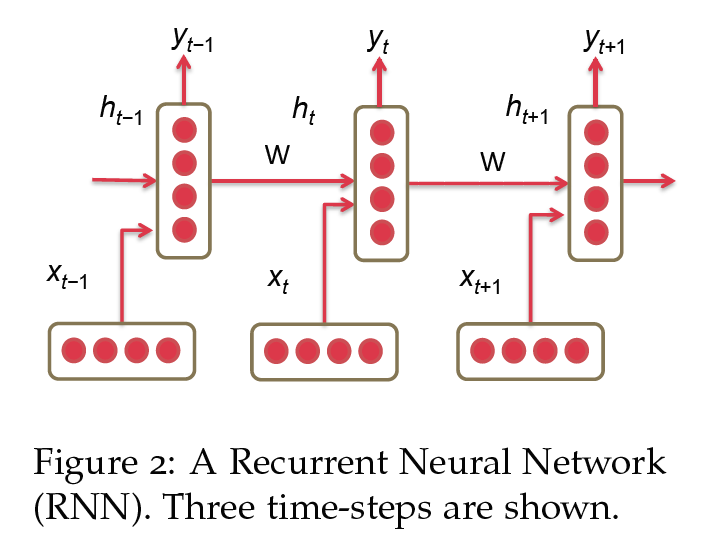

---
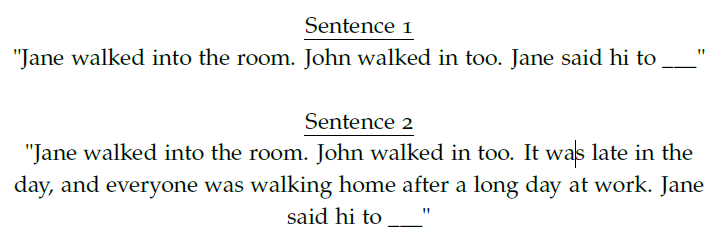

---
### Basic RNN Feed-forward equations:
$$
    \begin{align}
            h_t & = \sigma\big( W^{hh} h_{t-1} + W^{hx} x_t \big)  \quad\quad (5)\\
            %
            \hat{y}_t & = \mathrm{softmax}\big(W^s h_t \big) \quad\quad(6)
    \end{align}
$$

- It is not easy for RNN to produce a high probability output for the word "John"
- Because Backpropagation does not work very well. Why?
    - The contribution of gradient values gradually vanishes as they propagate to earlier time-steps.
    - or it grows extremely large, resulting in NaN.

---

In [1]:
%matplotlib inline


Sequence Models and Long-Short Term Memory Networks
===================================================

- **Long Short-Term Memory, Neural Computation, Sepp Hochreiter and Jurgen Schmidhuber, 9(8):1735-1780, 1997**

At this point, we have seen various feed-forward networks. That is,
there is no state maintained by the network at all. This might not be
the behavior we want. Sequence models are central to NLP: they are
models where there is some sort of dependence through time between your
inputs. The classical example of a sequence model is the Hidden Markov
Model for part-of-speech tagging. Another example is the conditional
random field.

A recurrent neural network is a network that maintains some kind of
state. For example, its output could be used as part of the next input,
so that information can propogate along as the network passes over the
sequence. In the case of an LSTM, for each element in the sequence,
there is a corresponding *hidden state* $h_t$, which in principle
can contain information from arbitrary points earlier in the sequence.
We can use the hidden state to predict words in a language model,
part-of-speech tags, and a myriad of other things.


## LSTM's in Pytorch

Before getting to the example, note a few things. Pytorch's LSTM expects
all of its inputs to be 3D tensors. The semantics of the axes of these
tensors is important. The first axis is the sequence itself, the second
indexes instances in the mini-batch, and the third indexes elements of
the input. We haven't discussed mini-batching, so lets just ignore that
and assume we will always have just 1 dimension on the second axis. If
we want to run the sequence model over the sentence "The cow jumped",
our input should look like
$$
\begin{align}\begin{bmatrix}
   \overbrace{q_\text{The}}^\text{row vector} \\
   q_\text{cow} \\
   q_\text{jumped}
   \end{bmatrix}\end{align}
$$
Except remember there is an additional 2nd dimension with size 1.

In addition, you could go through the sequence one at a time, in which
case the 1st axis will have size 1 also.

Let's see a quick example.



### LSTM Illustration
- It has one more internal **context** variable compared to the generic RNN model.
- [See the beautiful visual explanation by Colah](https://colah.github.io/posts/2015-08-Understanding-LSTMs)

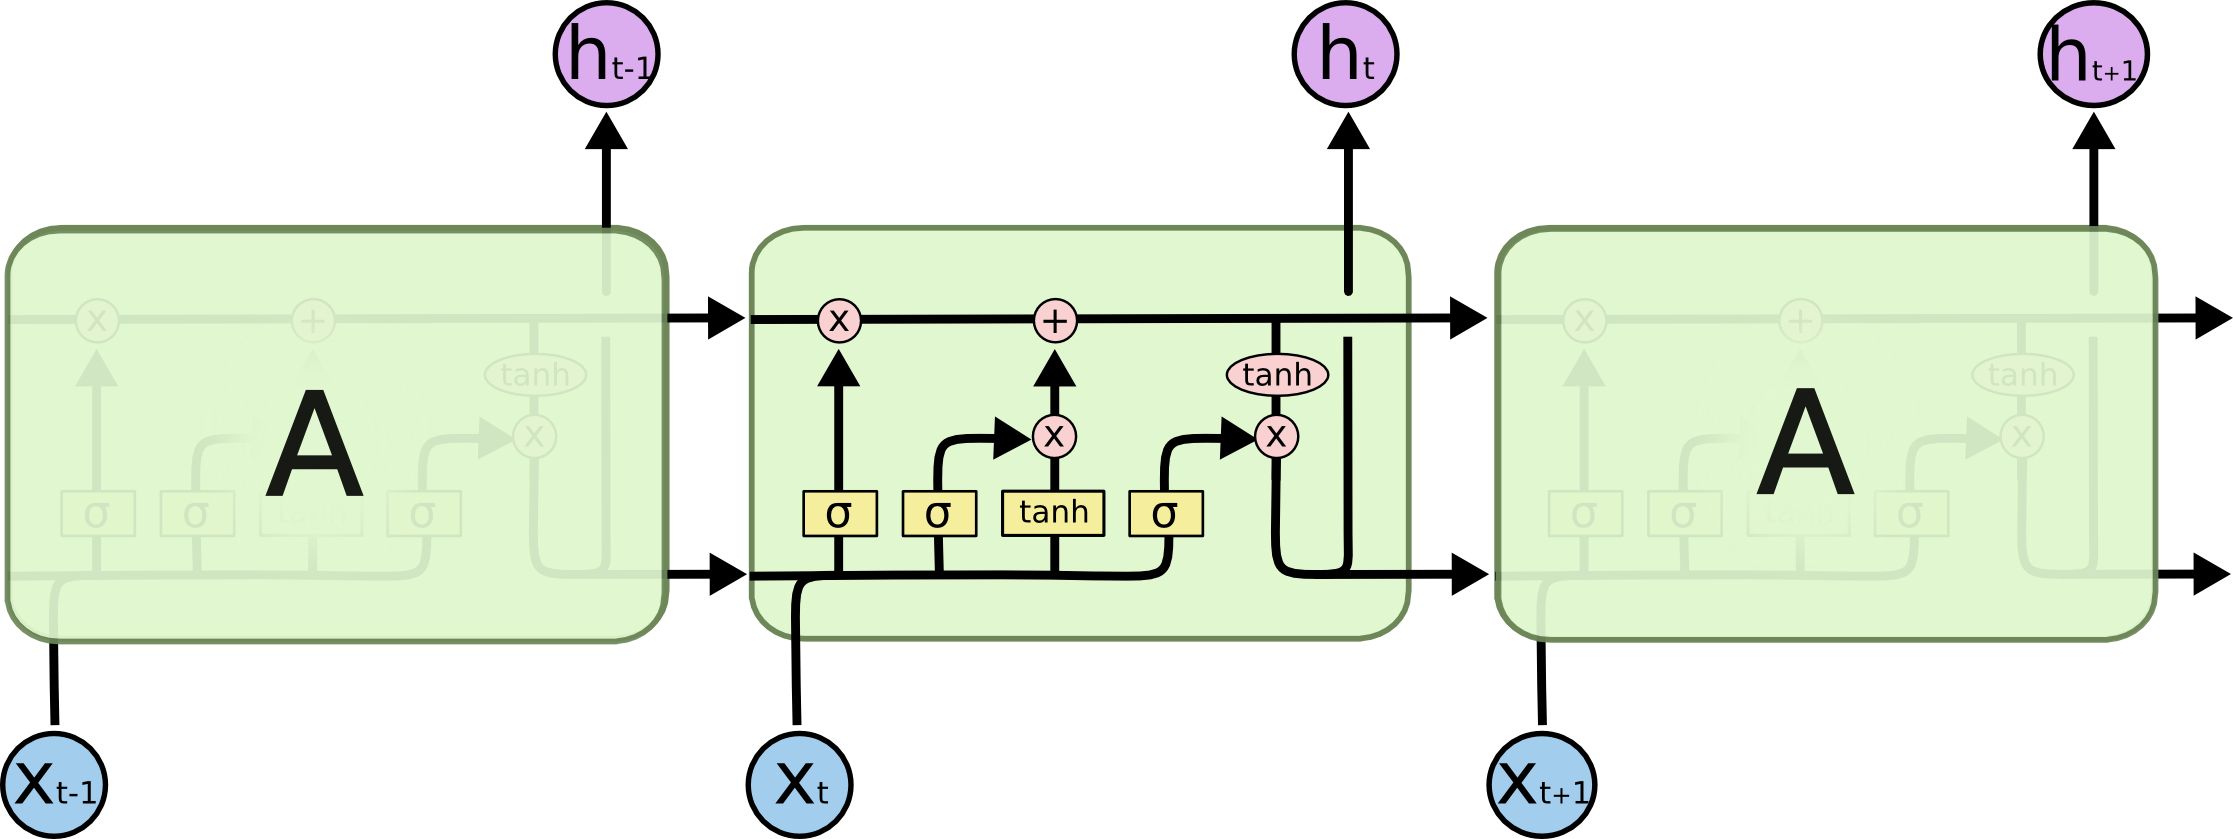

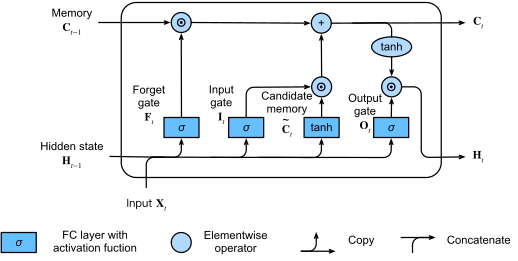

In [2]:
# figure source: https://d2l.ai/chapter_recurrent-modern/lstm.html
from IPython.display import SVG

SVG(filename='../figures/lstm_3.svg')

---
### LSTM in NLP



- See http://cs224d.stanford.edu/
- [Lecture Note of cs224d.stanford.edu, RNN for Language Modeling](http://cs224d.stanford.edu/lecture_notes/notes4.pdf)

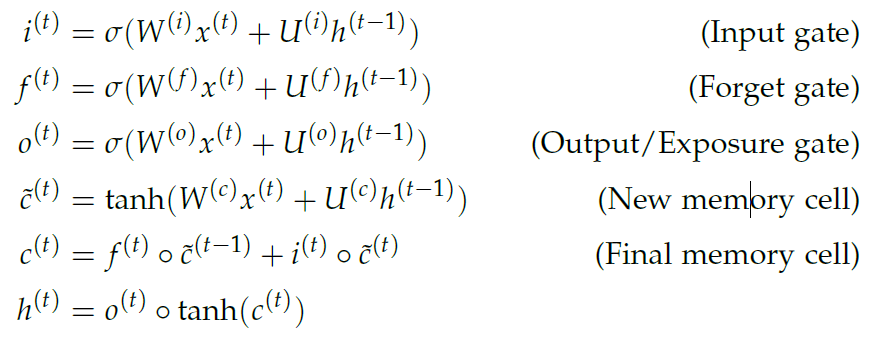

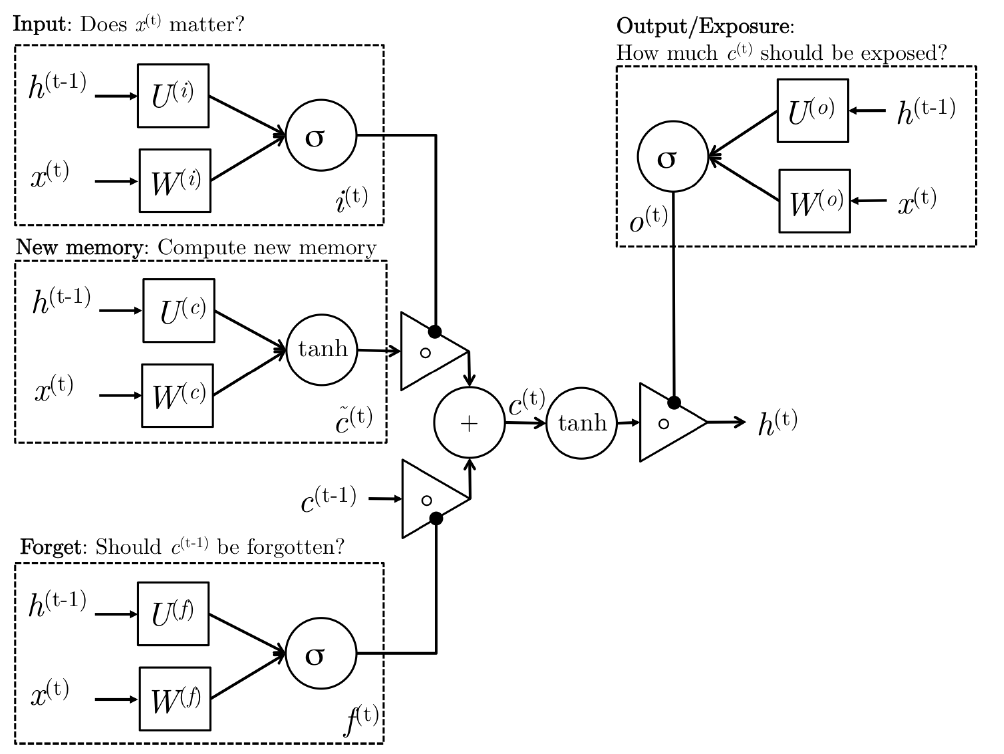

---
## LSTM

In [3]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

## LSTM in PyTorch

In [4]:
nn.LSTM?

Init signature: nn.LSTM(*args, **kwargs)
Docstring:     
Applies a multi-layer long short-term memory (LSTM) RNN to an input
sequence.


For each element in the input sequence, each layer computes the following
function:

.. math::
    \begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
        c_t = f_t * c_{(t-1)} + i_t * g_t \\
        h_t = o_t * \tanh(c_t) \\
    \end{array}

where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{(t-1)}`
is the hidden state of the layer at time `t-1` or the initial hidden
state at time `0`, and :math:`i_t`, :math:`f_t`, :math:`g_t`,
:math:`o_t` are the input, forget, cell, and output gates, respectively.
:m

### nn.LSTM(input, hidden)

In [5]:
dim_in = 3
dim_out = 4
#
lstm = nn.LSTM(input_size=dim_in, hidden_size=dim_out)  # Input dim is 3, output dim is 4
#
print(lstm)

LSTM(3, 4)


In [6]:
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
#
print('inputs: ', inputs)

inputs:  [tensor([[ 0.0939,  1.2381, -1.3459]]), tensor([[ 0.5119, -0.6933, -0.1668]]), tensor([[-0.9999, -1.6476,  0.8098]]), tensor([[ 0.0554,  1.1340, -0.5326]]), tensor([[ 0.6592, -1.5964, -0.3769]])]


### one-by-one iteration through for-loop

In [7]:
# initialize the hidden state: (h_0, C_0)
# Notice: intitial hidden state: requires_grad=False
hidden = (torch.randn(1, 1, dim_out),
          torch.randn(1, 1, dim_out))

# Then for-loop
# Step through the sequence one element at a time.
# after each step, hidden contains the tuple (h_t, C_t)
for i in inputs:
    ii = i.view(1,1,-1) # Batch dimension required everytime
    out, hidden = lstm(ii, hidden)
    print(f'in: {ii.shape}  --> {out.shape} {hidden[0].shape} {hidden[1].shape}')
#
print('----')
print('The output == hidden')
print('output:          ', out)
print('h_t = hidden[0]: ', hidden[0])
print('C_t = hidden[1]: ', hidden[1])

in: torch.Size([1, 1, 3])  --> torch.Size([1, 1, 4]) torch.Size([1, 1, 4]) torch.Size([1, 1, 4])
in: torch.Size([1, 1, 3])  --> torch.Size([1, 1, 4]) torch.Size([1, 1, 4]) torch.Size([1, 1, 4])
in: torch.Size([1, 1, 3])  --> torch.Size([1, 1, 4]) torch.Size([1, 1, 4]) torch.Size([1, 1, 4])
in: torch.Size([1, 1, 3])  --> torch.Size([1, 1, 4]) torch.Size([1, 1, 4]) torch.Size([1, 1, 4])
in: torch.Size([1, 1, 3])  --> torch.Size([1, 1, 4]) torch.Size([1, 1, 4]) torch.Size([1, 1, 4])
----
The output == hidden
output:           tensor([[[-0.0555,  0.1150, -0.0278, -0.2113]]], grad_fn=<StackBackward>)
h_t = hidden[0]:  tensor([[[-0.0555,  0.1150, -0.0278, -0.2113]]], grad_fn=<StackBackward>)
C_t = hidden[1]:  tensor([[[-0.0925,  0.5438, -0.0717, -0.3445]]], grad_fn=<StackBackward>)


### LSTM as automatic for-loop 

- Alternatively, we can do the entire sequence all at once.
- the first value returned by LSTM is all of the hidden states throughout the sequence. 
- the second is just the most recent hidden state (compare the last slice of "out" with "hidden" below, they are the same)
- The reason for this is that:
    - "out" will give you access to all hidden states in the sequence
    - "hidden" will allow you to continue the sequence and backpropagate, by passing it as an argument  to the lstm at a later time


In [8]:
# one channel sequence of length 5, each element is of 3 dim. 
inputseq = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
inputseq = torch.cat(inputseq); 
print('inputseq: ', inputseq.shape)

inputs = inputseq.unsqueeze(1) #view(len(inputs), 1, -1)
print('inputs: ', inputs.shape, ' SeqLen x Batch x FeatDim')

hidden = (torch.zeros(1, 1, dim_out), torch.zeros(1, 1, dim_out))  # clean out hidden state

inputseq:  torch.Size([5, 3])
inputs:  torch.Size([5, 1, 3])  SeqLen x Batch x FeatDim


In [9]:
out, hidden = lstm(inputs, hidden)
print(f'{inputs.shape} --> {out.shape}')
print('out[-1]:', out[-1]) # the last of the LSTM output
print(f'hidden: {hidden[0]}\n        {hidden[1]}')

torch.Size([5, 1, 3]) --> torch.Size([5, 1, 4])
out[-1]: tensor([[-0.0877,  0.1719,  0.0691, -0.2509]], grad_fn=<SelectBackward>)
hidden: tensor([[[-0.0877,  0.1719,  0.0691, -0.2509]]], grad_fn=<StackBackward>)
        tensor([[[-0.1615,  0.3370,  0.1913, -0.5834]]], grad_fn=<StackBackward>)


### Swap Batch Dimension & Time Dimension
-  Batch dimension can go first with `batch_first=True`

In [10]:
lstm_bf = nn.LSTM(input_size=dim_in, hidden_size=dim_out, batch_first=True)  # Input dim is 3, output dim is 4
inputseq = [torch.randn(1,3) for _ in range(5)]
inputseq = torch.cat(inputseq)
inputs = inputseq.unsqueeze(0) # B x T x F
print('inputs: ', inputs.shape, 'Batch x SeqLen x FeatDim')
print(inputs)

hidden = (torch.zeros(1, 1, dim_out), torch.zeros(1, 1, dim_out))  # clean out hidden state

inputs:  torch.Size([1, 5, 3]) Batch x SeqLen x FeatDim
tensor([[[-0.4891, -0.6175,  0.3836],
         [ 0.3852,  0.7890,  1.1363],
         [-0.1147, -0.0180,  0.0491],
         [ 0.4272, -0.8996,  0.5313],
         [ 0.4034,  1.4521, -2.4182]]])


In [11]:
out, hidden = lstm_bf(inputs, hidden)
print('out: ', out)
print('hidden: ', hidden)

out:  tensor([[[ 0.0228,  0.0340, -0.0764,  0.0323],
         [-0.0694,  0.0088, -0.0861,  0.0493],
         [ 0.0193, -0.0074, -0.1119,  0.1098],
         [-0.0109,  0.0148, -0.0194,  0.0756],
         [ 0.3320, -0.1343, -0.1002,  0.4591]]], grad_fn=<TransposeBackward0>)
hidden:  (tensor([[[ 0.3320, -0.1343, -0.1002,  0.4591]]], grad_fn=<StackBackward>), tensor([[[ 0.6707, -0.5680, -0.1672,  0.7828]]], grad_fn=<StackBackward>))


### Batch ($> 1$), batch_first=True

In [12]:
lstm_bf = nn.LSTM(input_size=dim_in, hidden_size=dim_out, batch_first=True)  # Input dim is 3, output dim is 4

inputs1 = [torch.randn(1,3) for _ in range(5)]
inputs1 = torch.cat(inputs1).unsqueeze(0)
inputs2 = [torch.randn(1,3) for _ in range(5)] # second sequence data
inputs2 = torch.cat(inputs2).unsqueeze(0)

inputs = torch.cat([inputs1, inputs2], dim=0)
print('inputs: ', inputs.shape, 'Batch x SeqLen x FeatDim')
print(inputs)

batch_size = 2

# Hidden State must keep the order (Time=1, Batch, Feature)
hidden = (torch.randn(1, batch_size, dim_out), torch.randn(1, batch_size, dim_out))  # clean out hidden state

inputs:  torch.Size([2, 5, 3]) Batch x SeqLen x FeatDim
tensor([[[-1.1906e+00,  8.4825e-03,  6.7802e-02],
         [-2.0429e-01, -5.2431e-01, -3.0885e-01],
         [ 4.4440e-01, -9.8635e-01, -1.8248e+00],
         [ 5.9887e-01,  1.1414e+00,  3.1890e-02],
         [ 3.7484e-01, -1.1240e-03,  9.8855e-01]],

        [[ 1.0795e+00, -1.5461e+00,  1.1264e-01],
         [-1.8664e+00, -1.0945e+00,  3.0690e-01],
         [ 1.5775e+00, -6.7307e-01,  1.7090e+00],
         [ 2.2873e-01,  7.1360e-01, -1.3605e+00],
         [ 3.9173e-01, -2.7825e-02,  8.7387e-01]]])


In [13]:
out, hidden = lstm_bf(inputs, hidden)

print(f'out: {out.shape}')
print(f'{out}')
print('hidden: ', hidden[0].shape, hidden[1].shape)
print(hidden[0])
print(hidden[1])

out: torch.Size([2, 5, 4])
tensor([[[ 0.0561, -0.4648,  0.1586, -0.3609],
         [-0.0243, -0.2113,  0.0062, -0.2592],
         [-0.0860, -0.1399, -0.0864, -0.0894],
         [-0.0043, -0.1132, -0.2122, -0.1195],
         [-0.0810, -0.0069, -0.1276, -0.2148]],

        [[-0.4200,  0.0312,  0.1551, -0.1239],
         [-0.0709, -0.1121,  0.0480, -0.1346],
         [-0.2942,  0.0911, -0.0136, -0.2824],
         [-0.0581,  0.0532, -0.2214, -0.0657],
         [-0.1000,  0.0559, -0.1289, -0.1828]]], grad_fn=<TransposeBackward0>)
hidden:  torch.Size([1, 2, 4]) torch.Size([1, 2, 4])
tensor([[[-0.0810, -0.0069, -0.1276, -0.2148],
         [-0.1000,  0.0559, -0.1289, -0.1828]]], grad_fn=<StackBackward>)
tensor([[[-0.1623, -0.0172, -0.2900, -0.3154],
         [-0.2125,  0.1459, -0.2957, -0.2726]]], grad_fn=<StackBackward>)


### Multiple Batch (> 1), batch_first=False

In [14]:
lstm = nn.LSTM(input_size=dim_in, hidden_size=dim_out)  # Input dim is 3, output dim is 4

inputs1 = [torch.randn(1,3) for _ in range(5)]
inputs1 = torch.cat(inputs1).unsqueeze(1)  #.view(len(inputs1), 1, -1)
inputs2 = [torch.randn(1,3) for _ in range(5)] # second sequence data
inputs2 = torch.cat(inputs2).unsqueeze(1)  #view(len(inputs2), 1, -1)
print('inputs1: ', inputs1.shape)

inputs = torch.cat([inputs1, inputs2], dim=1)
print('inputs: ', inputs.shape, 'SeqLen x Batch x FeatDim')
print(inputs)

batch_size = 2

# Hidden Vector keeps the order (Time, Batch, Feature)
hidden = (torch.zeros(1, batch_size, dim_out), 
          torch.zeros(1, batch_size, dim_out))  # clean out hidden state

inputs1:  torch.Size([5, 1, 3])
inputs:  torch.Size([5, 2, 3]) SeqLen x Batch x FeatDim
tensor([[[ 0.5239, -0.9056, -0.5866],
         [ 0.6033,  1.7672, -0.5837]],

        [[ 1.0355,  0.6981,  1.1381],
         [ 1.1813, -2.5713,  0.0931]],

        [[-0.4953, -0.3751,  0.5186],
         [ 1.1526, -1.4169, -0.4190]],

        [[-0.6789,  1.4190,  0.8329],
         [ 3.2469, -0.3057,  0.0609]],

        [[-1.8374,  1.0549, -0.5672],
         [ 0.2798,  0.8781, -0.1667]]])


In [15]:
out, hidden = lstm(inputs, hidden)
print('out: ', out.shape)
print(f'{out}')
print('hidden: ', hidden[0].shape, hidden[1].shape)

#
print('# the output at the last of the time sequence is equal to hidden[0].')
print('# hidden[1] is internal context.')
print('output[-1] - hidden[0]:')
print(out[-1] - hidden[0])

out:  torch.Size([5, 2, 4])
tensor([[[-0.0624,  0.0402, -0.1452,  0.0209],
         [ 0.0446, -0.1727, -0.2882,  0.2619]],

        [[-0.0046,  0.0534, -0.1761,  0.0559],
         [-0.1587,  0.0172,  0.0389,  0.0333]],

        [[ 0.0198,  0.0842, -0.1500,  0.0783],
         [-0.1874,  0.1940, -0.0620,  0.0182]],

        [[ 0.0871, -0.1102, -0.3068,  0.3000],
         [-0.0895,  0.2475, -0.1151, -0.0030]],

        [[ 0.1880, -0.2737, -0.5211,  0.5153],
         [-0.0643, -0.0293, -0.2963,  0.1779]]], grad_fn=<StackBackward>)
hidden:  torch.Size([1, 2, 4]) torch.Size([1, 2, 4])
# the output at the last of the time sequence is equal to hidden[0].
# hidden[1] is internal context.
output[-1] - hidden[0]:
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<SubBackward0>)


---
## Example: A Toy LSTM Network for Part-of-Speech Tagging

In this section, we will use an LSTM to get part of speech tags. We will
not use Viterbi or Forward-Backward or anything like that, but as a
(challenging) exercise to the reader, think about how Viterbi could be
used after you have seen what is going on.

The model is as follows: let our input sentence be
$w_1, \dots, w_M$, where $w_i \in V$, our vocab. Also, let
$T$ be our tag set, and $y_i$ the tag of word $w_i$.
Denote our prediction of the tag of word $w_i$ by
$\hat{y}_i$.

This is a structure prediction, model, where our output is a sequence
$\hat{y}_1, \dots, \hat{y}_M$, where $\hat{y}_i \in T$.

To do the prediction, pass an LSTM over the sentence. Denote the hidden
state at timestep $i$ as $h_i$. Also, assign each tag a
unique index (like how we had word\_to\_ix in the word embeddings
section). Then our prediction rule for $\hat{y}_i$ is

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(Ah_i + b))_j\end{align}

That is, take the log softmax of the affine map of the hidden state,
and the predicted tag is the tag that has the maximum value in this
vector. Note this implies immediately that the dimensionality of the
target space of $A$ is $|T|$.

### Prepare Data

In [16]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [17]:
training_data

[(['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN']),
 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN'])]

In [18]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


for i, td in enumerate(training_data):
    print(i, td)

# word --> index (vocabulary construction)
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
#
print(f'w2ix: length: {len(word_to_ix)}\n{word_to_ix}')

# Only three tags. Simply declared.
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}
tags = [ k for k, v in tag_to_ix.items() ]

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 7

0 (['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN'])
1 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN'])
w2ix: length: 9
{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [19]:
tags

['DET', 'NN', 'V']

### Create the model:

In [20]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=False)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence, flag=False):
        if flag: print('sentence_in: ', sentence.shape)
        embeds = self.word_embeddings(sentence)
        if flag: print('word_embeddings out: ', embeds.shape)
        
        if flag: print('embeds: ', embeds.view(len(sentence), 1, -1).shape, 'shape conversion for lstm')
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        if flag: print('lstm_out: ', lstm_out.shape)
        
        if flag: print('hidden2tag(Linear) in: ', lstm_out.view(len(sentence), -1).shape, 'converstion for Linear()')
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        if flag: print('Linear() out: ', tag_space.shape)
        tag_scores = F.log_softmax(tag_space, dim=1)
        if flag: print('softmax out: ', tag_scores.shape)
            
        return tag_scores

In [21]:
# sanity check
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

sentence, tags = training_data[0]
sentence_in = prepare_sequence(sentence, word_to_ix)
targets = prepare_sequence(tags, tag_to_ix)

pred = model(sentence_in, flag=True)

sentence_in:  torch.Size([5])
word_embeddings out:  torch.Size([5, 6])
embeds:  torch.Size([5, 1, 6]) shape conversion for lstm
lstm_out:  torch.Size([5, 1, 7])
hidden2tag(Linear) in:  torch.Size([5, 7]) converstion for Linear()
Linear() out:  torch.Size([5, 3])
softmax out:  torch.Size([5, 3])


---
### Fix the Model to accomodate multiple sentences
    - The lengths of input sequences may all different. Right?
    - But data in a mini-batch must have all the same lengths
    - Many approaches to manipulate this problem
        - trimming and zero padding
        - pack padded sequence
![Pack Padded Sequence](../figures/pack_padded_seq.jpg) <Figure Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Sequence-Labeling>

---
### Train the model:

In [22]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)
    am = torch.argmin(tag_scores, dim=1)
    print('argmin:', am)
    print([tags[k.item()] for k in am])

tensor([[-0.7415, -1.2698, -1.4159],
        [-0.7345, -1.3666, -1.3270],
        [-0.6882, -1.3866, -1.3958],
        [-0.6571, -1.4800, -1.3704],
        [-0.6937, -1.4160, -1.3564]])
argmin: tensor([2, 1, 2, 1, 1])
['V', 'NN', 'V', 'NN', 'NN']


In [23]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

loss_epochs = []

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    loss_value = 0
    for sentence, tags in training_data:
        # Step 1. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # print('sentence_in: ', sentence_in)
        
        # Step 2. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(' +++++ ')
        loss_value += loss.item()
    #
    loss_epochs.append(loss_value)
#

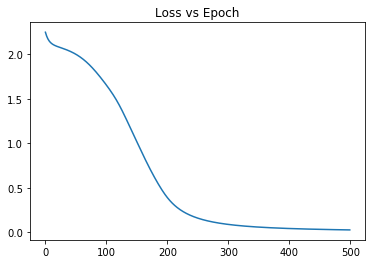

In [24]:
import matplotlib.pyplot as plt
plt.plot(loss_epochs)
plt.title('Loss vs Epoch');

In [25]:
# See what the scores are after training
with torch.no_grad():
    for data in training_data:
        sentence, gt_tag = data
        inputs = prepare_sequence(sentence, word_to_ix)
        tag_scores = model(inputs)

        # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
        # for word i. The predicted tag is the maximum scoring tag.
        # Here, we can see the predicted sequence below is 0 1 2 0 1
        # since 0 is index of the maximum value of row 1,
        # 1 is the index of maximum value of row 2, etc.
        # Which is DET NOUN VERB DET NOUN, the correct sequence!
        print('tag_scores: \n', tag_scores)
        print('predicted:    ', torch.argmax(tag_scores, dim=1))
        print('Ground Truth: ', prepare_sequence(gt_tag, tag_to_ix))
        print(' --- ')

tag_scores: 
 tensor([[-0.0136, -4.7479, -5.3369],
        [-4.7152, -0.0101, -6.8579],
        [-4.0501, -6.2829, -0.0195],
        [-0.0276, -4.4956, -4.1298],
        [-4.9120, -0.0082, -7.1734]])
predicted:     tensor([0, 1, 2, 0, 1])
Ground Truth:  tensor([0, 1, 2, 0, 1])
 --- 
tag_scores: 
 tensor([[-4.9781, -0.0085, -6.4741],
        [-4.2697, -5.3133, -0.0191],
        [-0.0123, -5.0042, -5.2088],
        [-5.0159, -0.0074, -7.1611]])
predicted:     tensor([1, 2, 0, 1])
Ground Truth:  tensor([1, 2, 0, 1])
 --- 


- This notebook is only to see a usage of LSTM!
- Dont misunderstand.

---
## Now where to go
- [Sequence Labeling Tutorial by sgrvinod, github.com](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Sequence-Labeling)
- [Text Analysis Tutorials by Bentrevett, github.com](https://github.com/bentrevett)
    

## Assignment

- Read the explanation about the idea of the architecture of GRU and make a summary report of your own in your ways using PyTorch
    - http://d2l.ai/chapter_recurrent-modern/index.html

---
End.